In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tifffile import imread
import cv2

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import keras
from keras import layers
from keras import initializers

keras.utils.set_random_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Problem Description

The goal of this project is to build and analyze models for the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) competition based on the [provided](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) dataset. We will perform the standard EDA, Analysis/Modeling, Results overview, and Conclusion.

The high level overview of the competition is a binary classification problem of identifying metastatic cancer given image patches taken from larger pathology scans.

The data description specifies that the center 32x32 pixels should be used to identify a positive sample, though the images may be larger to account for non-zero-padded convolutions. The provided training labels map training filenames to true values.

# EDA

Here we will perform data loading and Exploratory Data Analysis.

Training images are provided under the `train` directory and associated labels are in `train_labels.csv`. We will first load the data and get a high level overview of the shape and contents.

In [3]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_df.shape)

(220025, 2)


In [4]:
print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


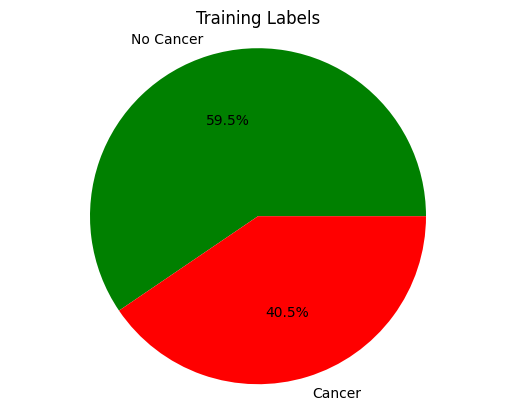

In [5]:
plt.pie(train_df['label'].value_counts(), labels=['No Cancer', 'Cancer'], colors=['green', 'red'], autopct='%1.1f%%')

plt.axis('equal')
plt.title('Training Labels')
plt.show()

In [6]:
train_files = os.listdir(train_dir)
train_files[:5]

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif',
 '092d0eedebce504847715ee046b6ad74b57599b4.tif',
 'b0d2582c6218a8764323fc940b41312282b99bf4.tif',
 '187c99df762f13f99818e5593d4bab4c6577e7e3.tif',
 '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']

In [7]:
img_0 = imread(os.path.join(train_dir, train_files[0]))
img_0.shape

(96, 96, 3)

The training dataset contains **220025** examples, with the number of labels matching the number of files under `train`. The image format is TIFF and uses the common `.tif` extension. Images are 96x96 pixels with 3 channels (presumably RGB). Roughly 40% of the training images are labeled positive for cancer.

We can now view a random sampling of the images along with their associated labels. To the untrained eye, it's difficult to determine what might indicate possible cancerous tissue.

In [8]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + iid + '.tif'
    # print(f'Loading {iid} from {path}')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

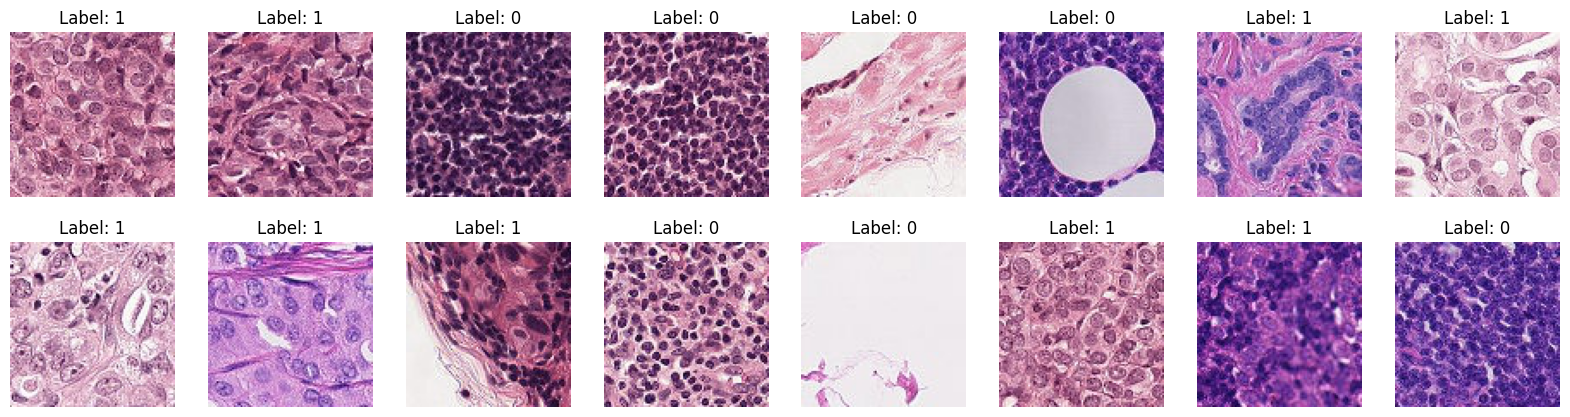

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
for idx, i in enumerate(np.random.choice(train_df['id'], 16)):
    img = load_image(i)
    axes.flat[idx].imshow(img)
    axes.flat[idx].axis('off')
    id = i.split('.')[0]
    l = train_df[train_df.id == id].values[0][1]
    axes.flat[idx].set_title(f'Label: {l}')


Finally, we can get a view of RGB mean/std and pixel value distributions. The dataset is large, so we'll take a random subsample, compute the mean/std of each channel, and display a histogram of pixel "strength".

Overall, the mean/std results look reasonable and don't indicate any strange patterns that we may need to investigate, and the strength distribution show that more of the pixel space has non-zero values than not, indicating more image space is filled with something vs. blank.

In [10]:
image_samples = np.array([load_image(id) for id in np.random.choice(train_df['id'], 5000)])

Mean pixel values (R,G,B): [179.54671233 140.13740747 178.04624421]
Std pixel values (R,G,B): [60.99976511 72.28502794 55.27051975]


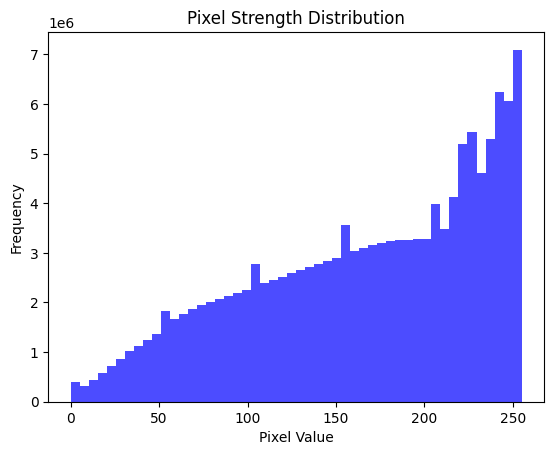

In [11]:
# Get the mean and stddev of pixels per channel (RGB color)
mean_pixel = np.mean(image_samples, axis=(0,1,2))  # Mean per channel
std_pixel = np.std(image_samples, axis=(0,1,2))  # Std deviation per channel

print(f"Mean pixel values (R,G,B): {mean_pixel}")
print(f"Std pixel values (R,G,B): {std_pixel}")

# Histogram of pixel values
plt.hist(image_samples.ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Strength Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


# Modeling/Analysis

We'll now move on to building and training a model.

## Preprocessing

Some preprocessing is necessary to get the data in shape for training. First, we noted above that the dataset is quite large, which could results in very long training runs or OOMs in our relatively small Kaggle session (we only get 30 GiB of RAM) if we were to try to preload all images. To work around this limitation, we'll train on a subset of the full dataset and make sure the positive and negative examples have an even representation.

In [12]:
# Create a smaller dataset with equal number of positive and negative examples.
TRAIN_SIZE_PER_LABEL=20000
negative = train_df[train_df['label'] == 0].sample(TRAIN_SIZE_PER_LABEL)
positive = train_df[train_df['label'] == 1].sample(TRAIN_SIZE_PER_LABEL)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)
train_df_small = neg_and_pos.sample(frac=1).reset_index(drop=True)

In [13]:
# Create X and y for training based on the smaller dataset.
X = np.array([load_image(i) for i in train_df_small['id']])
y = train_df_small['label'].values

Additional preprocessing will happen as initial layers in the model itself (see below).

## Model Build and Training

The Dataset is ready, so we'll move on to building and training a model.

### Model Preprocessing

Some preprocessing will be completed as initial layers in the model. Notably, we'll use `Rescaling` to scale the RGB values between 0 and 255, and `Cropping2D` to only train on the center 32x32px image as specified in the problem.

### Model #1 Architecture

The starting model architecture is relatively simple. After the preprocessing layers, we have three Convolution + MaxPooling layers for encoding, followed by a single fully connected layer funneling down (through a dropout) to the final sigmoid. The Convolution layers progressively increase the number of filters/kernels from 32 to 128.

In [14]:
# Original Simple Model
m1 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),
    layers.Cropping2D(cropping=32),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
m1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,041 (621.25 KB)

 Trainable params: 159,041 (621.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
es1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h1 = m1.fit(X, y, validation_split=0.2, epochs=50, callbacks=[es1])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6707 - auc: 0.7257 - loss: 0.6102 - val_accuracy: 0.7419 - val_auc: 0.8078 - val_loss: 0.5417
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7478 - auc: 0.8104 - loss: 0.5330 - val_accuracy: 0.7462 - val_auc: 0.8163 - val_loss: 0.5312
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7517 - auc: 0.8196 - loss: 0.5222 - val_accuracy: 0.7514 - val_auc: 0.8232 - val_loss: 0.5233
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7601 - auc: 0.8260 - loss: 0.5139 - val_accuracy: 0.7576 - val_auc: 0.8288 - val_loss: 0.5156
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7628 - auc: 0.8323 - loss: 0.5059 - val_accuracy: 0.7621 - val_auc: 0.8332 - val_loss: 0.5112
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7669 - auc: 0.8370 - loss: 0.4991 - val_accuracy: 0.7616 - val_auc: 0.8347 - val_loss: 0.5100
Epoch 7/50
1000/1000 ━━━━━━━

In [16]:
# Prepare test data for evaluation.
test_files = os.listdir(test_dir)
test_ids = [f.split('.')[0] for f in test_files]
test_X = np.array([load_image(i, image_dir=test_dir) for i in test_ids])

In [17]:
results = m1.predict(test_X)
results = results.reshape(-1)
results.shape

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


(57458,)

In [18]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': results.tolist(),
})

In [19]:
# # Uncomment to create submission for Model #1
# results_df.to_csv('submission.csv', index=False)
# results_df.head()

Model #1 Kaggle submission public score: 0.8557

## Model #2 Architecture

To provide an additional model for comparison, we'll train and submit results from a model with a slightly more complex architecture. Model #2 will be deeper with five Convolution layers, and will add `BatchNormalization` layers after each `Conv2D` to help with stability and potentially increase training efficiency with the larger number of parameters. Similar to Model #1, we funnel down through fully connected layers (with dropout during training) to the final sigmoid.

In [20]:
# More Complex Model
m2 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),
    # layers.Cropping2D(cropping=32),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
m2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │              

 Total params: 1,704,129 (6.50 MB)

 Trainable params: 1,702,145 (6.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [21]:
es2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h2 = m2.fit(X, y,
            validation_split=0.2,
            epochs=50,
            callbacks=[es2],
           )

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7472 - auc: 0.8234 - loss: 0.5918 - val_accuracy: 0.8119 - val_auc: 0.8989 - val_loss: 0.4276
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8177 - auc: 0.8952 - loss: 0.4122 - val_accuracy: 0.7819 - val_auc: 0.9054 - val_loss: 0.5072
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8412 - auc: 0.9173 - loss: 0.3674 - val_accuracy: 0.8158 - val_auc: 0.9199 - val_loss: 0.4258
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8660 - auc: 0.9378 - loss: 0.3196 - val_accuracy: 0.8253 - val_auc: 0.9237 - val_loss: 0.4281
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8952 - auc: 0.9599 - loss: 0.2565 - val_accuracy: 0.8138 - val_auc: 0.9131 - val_loss: 0.5363
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9323 - auc: 0.9809 - loss: 0.1762 - val_accuracy: 0.8285 - val_auc: 0.9060 - val_loss: 0.5637
Epoch 7/50
1000/1000 ━━━━━

In [22]:
results = m2.predict(test_X)
results = results.reshape(-1)
results.shape

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


(57458,)

In [23]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': results.tolist(),
})

In [24]:
# # Uncomment to create submission for Model #2
# results_df.to_csv('submission.csv', index=False)
# results_df.head()

Model #2 Kaggle submission public score: 0.9216

In [25]:
# More Complex Model (Deeper Classification Layers)
m3 = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),
    # layers.Cropping2D(cropping=32),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (2,2), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])
m3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
m3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 2,612,929 (9.97 MB)

 Trainable params: 2,610,945 (9.96 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [26]:
es3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
h3 = m3.fit(X, y,
            validation_split=0.2,
            epochs=50,
            callbacks=[es3],
           )

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7234 - auc: 0.7929 - loss: 0.6168 - val_accuracy: 0.7956 - val_auc: 0.8836 - val_loss: 0.4416
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7966 - auc: 0.8753 - loss: 0.4470 - val_accuracy: 0.8016 - val_auc: 0.8986 - val_loss: 0.4329
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8199 - auc: 0.8970 - loss: 0.4076 - val_accuracy: 0.8148 - val_auc: 0.9124 - val_loss: 0.4185
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8362 - auc: 0.9135 - loss: 0.3750 - val_accuracy: 0.7605 - val_auc: 0.9142 - val_loss: 0.5633
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8480 - auc: 0.9258 - loss: 0.3482 - val_accuracy: 0.8256 - val_auc: 0.9098 - val_loss: 0.4022
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8692 - auc: 0.9407 - loss: 0.3132 - val_accuracy: 0.8067 - val_auc: 0.8956 - val_loss: 0.4728
Epoch 7/50
1000/1000 ━━━━━

In [27]:
results = m3.predict(test_X)
results = results.reshape(-1)
results.shape

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


(57458,)

In [28]:
results_df = pd.DataFrame({
    'id': test_ids,
    'label': results.tolist(),
})

In [29]:
# Uncomment to create submission for Model #3.
results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.055257
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.007301
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.124246
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.134422
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.404782


Model #3 Kaggle submission public score: 0.9063

# Results

Overall, Model #2 scored better than #1 and #3 with a 0.9216. This was using a random, balanced 40k training set.

| Model | Parameters | Kaggle Score |
| -------- | ------- | ------- |
| m1 | 159,041 | 0.8557 |
| m2 | 1,702,145 | 0.9216 |
| m3 | 2,610,945 | 0.9063 |

We also executed all model tests again, but instead using a 100k training set. The results from these runs are:

| Model | Parameters | Kaggle Score |
| -------- | ------- | ------- |
| m1 | 159,041 | 0.8455 |
| m2 | 1,702,145 | 0.9132 |
| m3 | 2,610,945 | 0.9088 |

These results show that more trainable parameters is not necessarily better as far as performance. A more complex model with a high number of parameters could easily overfit, and the extra training time may not be worth the cost depending on the accuracy requirements of a given problem.

From the training progression graphs below, we can see that Model #1 starts overfitting after approximately 6-7 epochs, indicated by the divergence of training and validation values across all metrics.

Model #2 appears to converge slightly faster at around 5-6 epochs, with the training/validation metric divergence coming after that. One interesting artifact to note is the validation metrics swinging pretty wildly after 5-6 epochs, possibly indicating a too large learning rate.

Model #3 has a deeper classification layer, which increased trainable parameters by ~1M, but did not improve the Kaggle score as compared to the simpler (fewer parameters) Model #2.

Finally, more than doubling the training set size for all model architectures did **not** improve the Kaggle score. This may hint that iterating on hyperparameters and architectures with a smaller training set may be beneficial before training with a larger dataset.

In [30]:
def graph_train_hist(h):
    # Graph of training/validation loss and accuracy.
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    auc = h.history['auc']
    val_auc = h.history['val_auc']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # AUC
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'r-', label='Training AUC')
    plt.plot(epochs, val_loss, 'b-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, accuracy, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

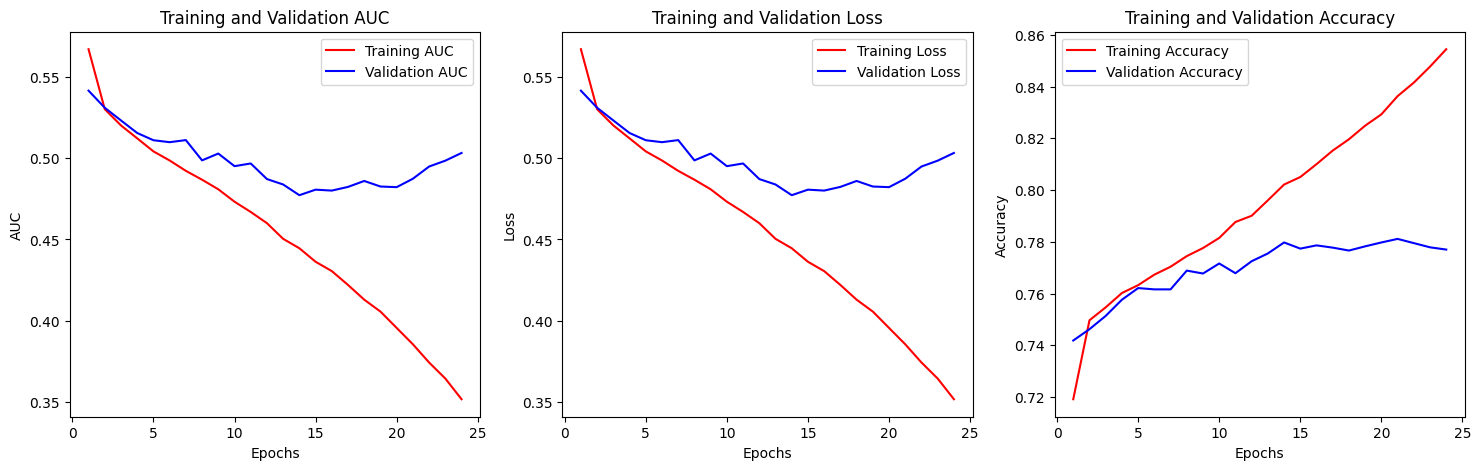

In [31]:
# Model #1 Training results (learning rate 0.001).

graph_train_hist(h1)

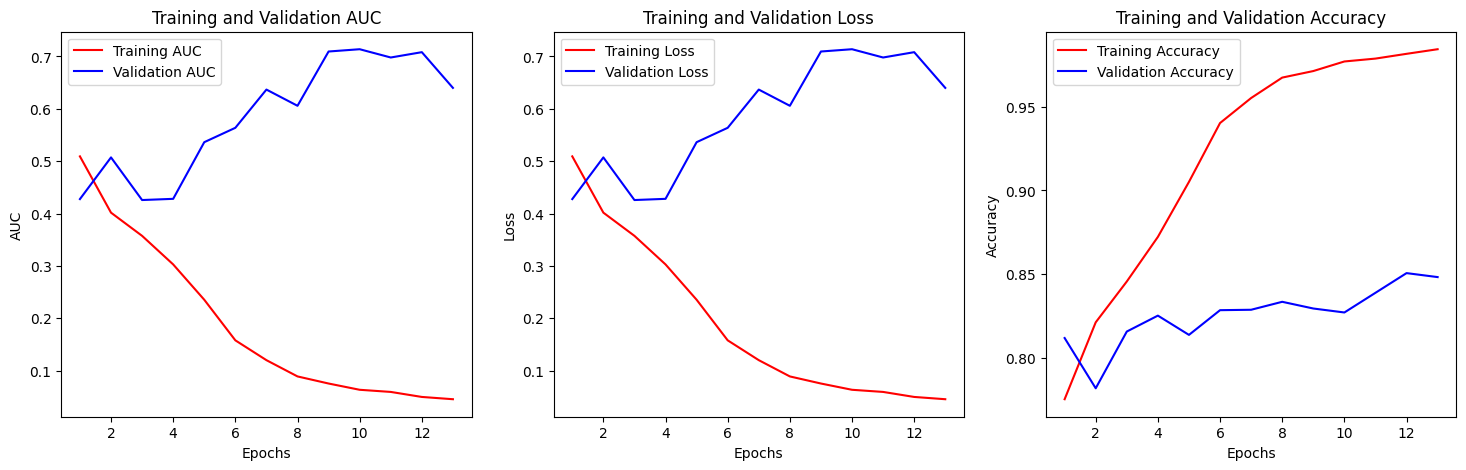

In [32]:
# Model #2 training results (learning rate 0.001).

graph_train_hist(h2)

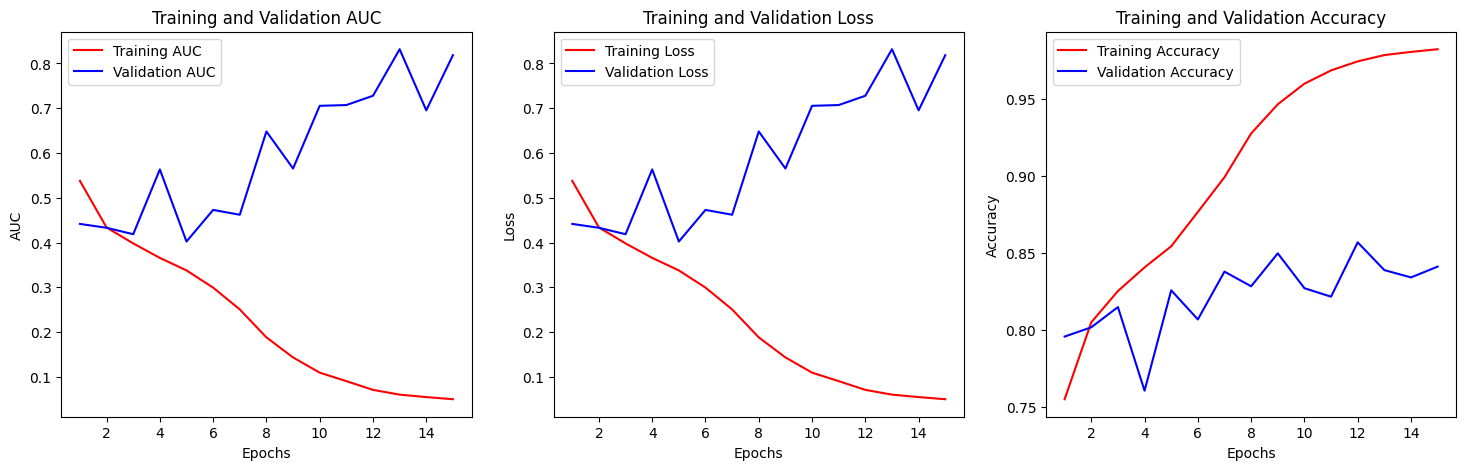

In [33]:
# Model #3 training results (learning rate 0.0001).

graph_train_hist(h3)

# Conclusion

The simple models above performed relatively well given the limitation of training on a subset of the data. We observed that increasing model depth and adding batchnorm layers increased the overall Kaggle score as expected.

Additional performance gains might be achieved with:
* Adding image augmentation layer(s) to artificially increase the training set (e.g., image rotations, skews, etc.)
* Adding dropout layers at each aggregate convolution layer
* Experimenting with different classifiers (e.g., random forest)
* Experimenting with non-default hyperparameters such as strides in the conv layers or momentum in the batchnorm layers
* Using input pipelines to allow training on the full training dataset without OOMs

The possibilities for knobs to tune are wide and varying, but we were able to show relatively good performance using mostly default hyperparameters with pretty generic CNN architectures.

## GitHub

This notbook is available under https://github.com/lynchrl/csca5642-wk3.

# References

* https://www.geeksforgeeks.org/reading-image-opencv-using-python/
* https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
* https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
* https://keras.io/api/layers/preprocessing_layers/image_preprocessing/center_crop/
* https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
* https://pandas.pydata.org/docs/reference/index.html
* https://keras.io/api/data_loading/
* https://www.geeksforgeeks.org/what-is-batch-normalization-in-deep-learning/
* https://www.tensorflow.org/tutorials/load_data/images
* https://keras.io/api/layers/preprocessing_layers/image_augmentation/rand_augment/